In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


## Making an ML regression model to predict the ride price

Reading the data set and using it as a dataframe.

In [5]:
raw_dataset = pd.read_csv('data/simpleData.csv')

In [6]:
raw_dataset.head()

,distance,destination_dict,source_dict,name_dict,cab_type_dict,price
0,0.44,0,0,1,0,11.0
1,1.08,1,1,3,0,27.5
2,1.11,2,2,9,1,7.5
3,0.72,3,3,3,0,26.0
4,3.24,1,3,0,0,3.5


Chekcing if there is any empty values in the dataset.

In [7]:
raw_dataset.isna().any()

distance            False
destination_dict    False
source_dict         False
name_dict           False
cab_type_dict       False
price               False
dtype: bool

In [8]:
# we can make a copy of the dataset
dataset = raw_dataset.copy()
dataset.tail()

,distance,destination_dict,source_dict,name_dict,cab_type_dict,price
96214,3.04,2,5,9,1,9.5
96215,3.04,2,5,6,1,16.5
96216,3.23,0,11,9,1,11.0
96217,3.22,0,11,11,1,10.0
96218,3.22,0,11,10,1,34.0


Splitting the dataset to train and test

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

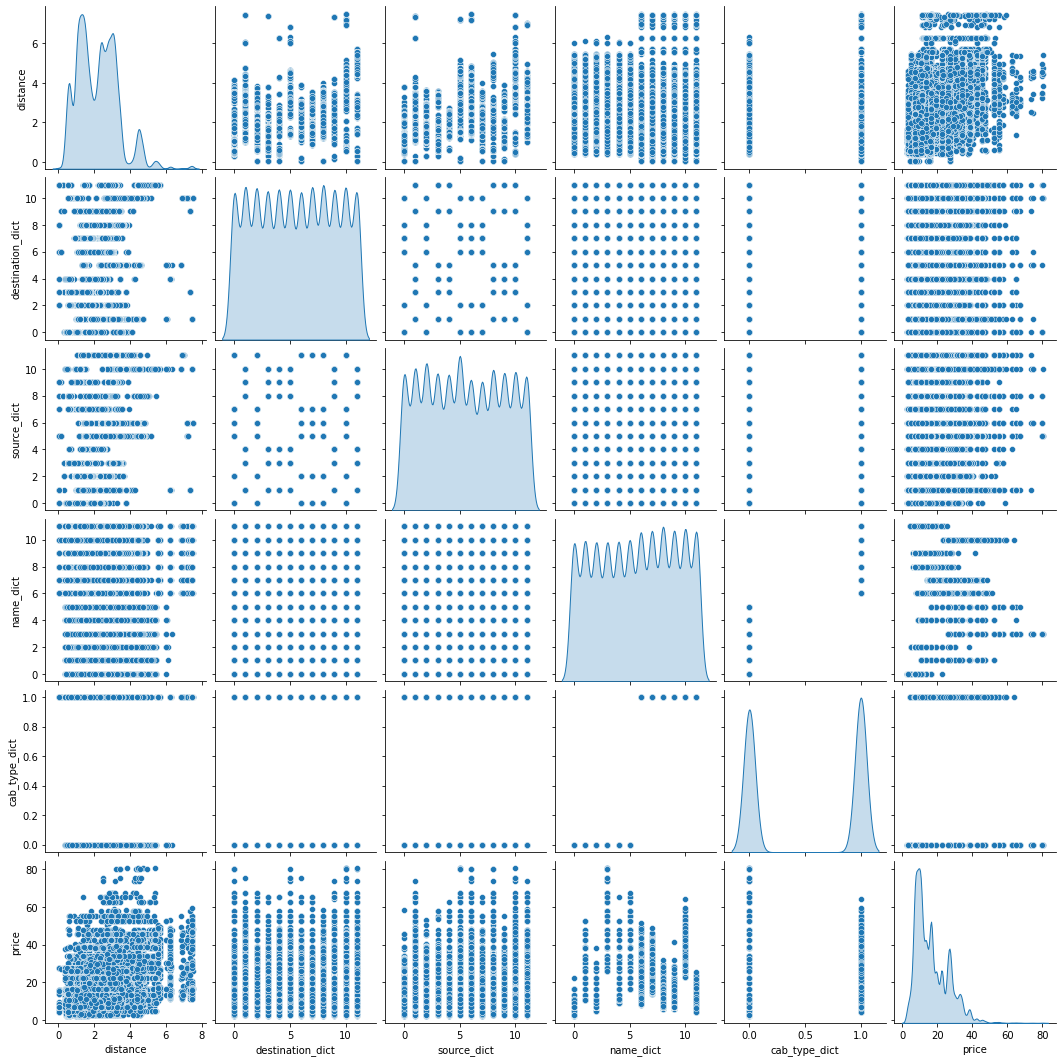

In [10]:
sns.pairplot(train_dataset[["distance",	"destination_dict",	"source_dict",	"name_dict",	"cab_type_dict", "price"]], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,76975.0,2.193796,1.132832,0.02,1.29,2.17,2.94,7.5
destination_dict,76975.0,5.507256,3.454743,0.00,2.00,6.00,8.50,11.0
source_dict,76975.0,5.453303,3.454540,0.00,2.00,5.00,8.00,11.0
name_dict,76975.0,5.624826,3.455424,0.00,3.00,6.00,9.00,11.0
cab_type_dict,76975.0,0.519948,0.499605,0.00,0.00,1.00,1.00,1.0
price,76975.0,16.540285,9.333152,2.50,9.00,13.50,22.50,80.5


In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

Normalizing the data to further processing.

In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

Testing a linear regression model. However from the plots before the price doesnt have a linear relation with the features. This means that the linear regression could be perform poorly.

In [16]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [18]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [19]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
1925/1925 - 5s - loss: 7.1513 - val_loss: 7.0013 - 5s/epoch - 2ms/step
Epoch 2/100
1925/1925 - 3s - loss: 6.8627 - val_loss: 6.9805 - 3s/epoch - 1ms/step
Epoch 3/100
1925/1925 - 3s - loss: 6.8660 - val_loss: 6.9790 - 3s/epoch - 1ms/step
Epoch 4/100
1925/1925 - 3s - loss: 6.8610 - val_loss: 6.9713 - 3s/epoch - 1ms/step
Epoch 5/100
1925/1925 - 2s - loss: 6.8662 - val_loss: 6.9821 - 2s/epoch - 1ms/step
Epoch 6/100
1925/1925 - 3s - loss: 6.8631 - val_loss: 6.9791 - 3s/epoch - 1ms/step
Epoch 7/100
1925/1925 - 3s - loss: 6.8647 - val_loss: 6.9616 - 3s/epoch - 1ms/step
Epoch 8/100
1925/1925 - 3s - loss: 6.8638 - val_loss: 6.9704 - 3s/epoch - 1ms/step
Epoch 9/100
1925/1925 - 2s - loss: 6.8627 - val_loss: 6.9877 - 2s/epoch - 1ms/step
Epoch 10/100
1925/1925 - 3s - loss: 6.8630 - val_loss: 6.9653 - 3s/epoch - 2ms/step
Epoch 11/100
1925/1925 - 3s - loss: 6.8609 - val_loss: 6.9917 - 3s/epoch - 1ms/step
Epoch 12/100
1925/1925 - 2s - loss: 6.8645 - val_loss: 7.0097 - 2s/epoch - 1ms/step
E

Plotting the loss

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

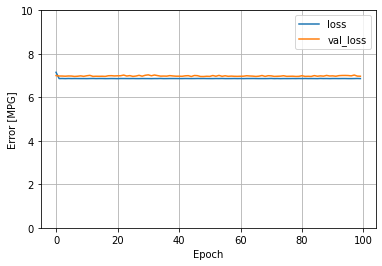

In [21]:
plot_loss(history)

From the plot, it is clear that the loss is not improved and hence the model was not performing as expected.

## Regression Model with DNN

In [23]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [24]:
dnn_model = build_and_compile_model(normalizer)

In [25]:
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                384       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                      

In [26]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
1925/1925 - 5s - loss: 6.1195 - val_loss: 5.5160 - 5s/epoch - 3ms/step
Epoch 2/100
1925/1925 - 4s - loss: 4.8241 - val_loss: 4.3056 - 4s/epoch - 2ms/step
Epoch 3/100
1925/1925 - 3s - loss: 3.0471 - val_loss: 2.4203 - 3s/epoch - 2ms/step
Epoch 4/100
1925/1925 - 3s - loss: 1.6128 - val_loss: 1.5288 - 3s/epoch - 2ms/step
Epoch 5/100
1925/1925 - 4s - loss: 1.4972 - val_loss: 1.4921 - 4s/epoch - 2ms/step
Epoch 6/100
1925/1925 - 3s - loss: 1.4772 - val_loss: 1.4920 - 3s/epoch - 2ms/step
Epoch 7/100
1925/1925 - 3s - loss: 1.4648 - val_loss: 1.4805 - 3s/epoch - 2ms/step
Epoch 8/100
1925/1925 - 3s - loss: 1.4467 - val_loss: 1.5761 - 3s/epoch - 2ms/step
Epoch 9/100
1925/1925 - 3s - loss: 1.4390 - val_loss: 1.4686 - 3s/epoch - 2ms/step
Epoch 10/100
1925/1925 - 3s - loss: 1.4275 - val_loss: 1.4963 - 3s/epoch - 2ms/step
Epoch 11/100
1925/1925 - 4s - loss: 1.4174 - val_loss: 1.4608 - 4s/epoch - 2ms/step
Epoch 12/100
1925/1925 - 4s - loss: 1.4126 - val_loss: 1.4948 - 4s/epoch - 2ms/step
E

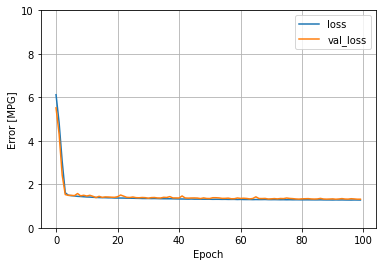

In [27]:
plot_loss(history)

The above plot shows the regression model with DNN showed considerable improvement in the loss. Hence we can use DNN based logistic regression for our application

We can also try to train the model with the entire dataframe and make it a bit more complex and check if the performance improves

In [29]:
dataset2 = pd.read_csv('data/cleanData.csv')

In [30]:
train_dataset2 = dataset2.sample(frac=0.8, random_state=0)
test_dataset2 = dataset2.drop(train_dataset2.index)

train_features2 = train_dataset2.copy()
test_features2 = test_dataset2.copy()

train_labels2 = train_features2.pop('price')
test_labels2 = test_features2.pop('price')

In [31]:
train_dataset2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,76975.0,2.193796,1.132832,0.0200,1.290,2.170,2.9400,7.500
destination_dict,76975.0,5.507256,3.454743,0.0000,2.000,6.000,8.5000,11.000
source_dict,76975.0,5.453303,3.454540,0.0000,2.000,5.000,8.0000,11.000
hour,76975.0,11.938448,7.259465,0.0000,5.000,14.000,18.0000,23.000
day_of_week,76975.0,2.610679,2.719619,0.0000,0.000,1.000,6.0000,6.000
day,76975.0,18.383501,10.084921,1.0000,16.000,26.000,26.0000,30.000
month,76975.0,11.468581,0.499015,11.0000,11.000,11.000,12.0000,12.000
year,76975.0,2018.000000,0.000000,2018.0000,2018.000,2018.000,2018.0000,2018.000
time_of_day,76975.0,3.663228,2.418003,0.0000,1.000,4.000,6.0000,7.000
temp,76975.0,42.549523,3.242480,34.1000,40.990,43.440,44.4200,51.240


In [32]:
normalizer2 = tf.keras.layers.Normalization(axis=-1)

In [33]:
normalizer2.adapt(np.array(train_features2))

In [34]:
dnn_model2 = build_and_compile_model(normalizer2)

In [35]:
dnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 16)               33        
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                1088      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                      

In [36]:
%%time
history = dnn_model2.fit(
    train_features2,
    train_labels2,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
1925/1925 - 6s - loss: 6.3281 - val_loss: 5.8411 - 6s/epoch - 3ms/step
Epoch 2/100
1925/1925 - 4s - loss: 4.5084 - val_loss: 3.4960 - 4s/epoch - 2ms/step
Epoch 3/100
1925/1925 - 4s - loss: 3.2195 - val_loss: 3.3941 - 4s/epoch - 2ms/step
Epoch 4/100
1925/1925 - 6s - loss: 3.1007 - val_loss: 3.1765 - 6s/epoch - 3ms/step
Epoch 5/100
1925/1925 - 4s - loss: 2.9872 - val_loss: 2.9779 - 4s/epoch - 2ms/step
Epoch 6/100
1925/1925 - 4s - loss: 2.8481 - val_loss: 2.7911 - 4s/epoch - 2ms/step
Epoch 7/100
1925/1925 - 4s - loss: 2.0966 - val_loss: 1.8490 - 4s/epoch - 2ms/step
Epoch 8/100
1925/1925 - 4s - loss: 1.5226 - val_loss: 1.5706 - 4s/epoch - 2ms/step
Epoch 9/100
1925/1925 - 4s - loss: 1.4912 - val_loss: 1.5142 - 4s/epoch - 2ms/step
Epoch 10/100
1925/1925 - 4s - loss: 1.4786 - val_loss: 1.5340 - 4s/epoch - 2ms/step
Epoch 11/100
1925/1925 - 5s - loss: 1.4694 - val_loss: 1.4904 - 5s/epoch - 3ms/step
Epoch 12/100
1925/1925 - 5s - loss: 1.4609 - val_loss: 1.4768 - 5s/epoch - 3ms/step
E

##Evaluating performance

In [37]:
test_results = {}

In [38]:
test_results['linear'] = linear_model.evaluate(test_features, test_labels, verbose=0)

In [39]:
test_results['dnn1'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [40]:
test_results['dnn2'] = dnn_model2.evaluate(test_features2, test_labels2, verbose=0)

In [41]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear,6.925209
dnn1,1.321058
dnn2,1.375200


So here we can see that the models dnn1 performed better the other two models.

Hence we can now hypertune the dnn1 model